In [67]:
# 1. Импорты и настройки

import requests
from bs4 import BeautifulSoup
import re
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor, as_completed

sns.set(style="whitegrid")
HEADERS = {'User-Agent': 'Mozilla/5.0'}

In [68]:
# 2. Парсинг товаров

def get_total_pages(base_url):
    response = requests.get(base_url, headers=HEADERS)
    if response.status_code != 200:
        return 1
    soup = BeautifulSoup(response.text, 'html.parser')
    pagination = soup.find('ul', class_='pagination')
    if not pagination:
        return 1
    pages = pagination.find_all('li')
    page_numbers = []
    for p in pages:
        try:
            num = int(p.text.strip())
            page_numbers.append(num)
        except:
            pass
    return max(page_numbers) if page_numbers else 1

def get_product_urls_from_page(url):
    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    container = soup.find('div', class_='row products-list')
    if not container:
        print(f"Не найден контейнер с товарами на странице {url}")
        return []
    product_divs = container.find_all('div', class_='product-layout')
    urls = []
    for product in product_divs:
        a_tag = product.find('a', href=True)
        if a_tag:
            href = a_tag['href']
            if href.startswith('/'):
                href = 'https://nimpha.ua' + href
            urls.append(href)
    return urls

def parse_product_detail(url):
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print(f"[!] Ошибка загрузки страницы товара: {url}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    # 1. Название товара
    name_tag = soup.find('h1', class_='product-name') or soup.find('h1')
    name = name_tag.text.strip() if name_tag else ''
    print(f"[DEBUG] Название товара: {name}")

    # 2. Характеристики
    attrs = {}

    # Способ 1: Ищем section по частичному совпадению класса
    spec_section = soup.find('section', class_=lambda x: x and 'section__product__specification' in x)
    
    # Способ 2: Альтернативный поиск по id (если есть)
    if not spec_section:
        spec_section = soup.find('section', id='section_product__specification')

    if spec_section:
        # Ищем все attribute_block внутри section
        attribute_blocks = spec_section.find_all('div', class_='attribute_block')
        for block in attribute_blocks:
            key = block.find('div', class_='attribute_name')
            val = block.find('div', class_='attribute_text')
            if key and val:
                key_text = key.text.strip()
                val_text = val.text.strip()
                attrs[key_text] = val_text
        print(f"[DEBUG] Извлечённые характеристики: {attrs}")
    else:
        print("[DEBUG] Блок характеристик не найден")

    # 3. Получение brand и diagonal
    brand = attrs.get('Бренд', '').strip()
    diagonal_raw = attrs.get('Діагональ екрану, дюймів', '').strip()
    diagonal = diagonal_raw.replace(',', '.') if diagonal_raw else ''

    # 4. Fallback: из заголовка (если не нашли в характеристиках)
    if not brand or not diagonal:
        title_text = name  # используем название, если нет отдельного заголовка
        if not brand:
            brand_match = re.search(r'Монітор.*?\s([A-ZА-Я][a-zа-яA-ZА-Я0-9]+)', title_text)
            if brand_match:
                brand = brand_match.group(1)
                print(f"[DEBUG] Найден бренд из заголовка: {brand}")

        if not diagonal:
            diag_match = re.search(r'(\d{1,2}(?:[.,]\d{1,2})?)\s*(дюйм|”|\"|\'|IPS)?', title_text, re.IGNORECASE)
            if diag_match:
                diagonal = diag_match.group(1).replace(',', '.')
                print(f"[DEBUG] Найдена диагональ из заголовка: {diagonal}")

    # 5. Цены
    old_price = new_price = ''
    price_block = soup.find('ul', class_='list-unstyled price')
    if price_block:
        old_li = price_block.find('li', class_='product-price-old')
        new_li = price_block.find('li', class_='product-price')
        if old_li:
            old_price = re.sub(r'[^\d]', '', old_li.get_text())
        if new_li:
            new_price = re.sub(r'[^\d]', '', new_li.get_text())
    if not old_price and new_price:
        old_price = new_price

    # 6. Код товара
    product_code = ''
    code_div = soup.find('div', class_='cod')
    if code_div:
        b_tag = code_div.find('b')
        if b_tag:
            product_code = b_tag.text.strip()

    # 7. Возврат результата
    print(f"[DEBUG] Итог: brand='{brand}', diagonal='{diagonal}', old_price='{old_price}', new_price='{new_price}', product_code='{product_code}'\n")
    return {
        'name': name,
        'brand': brand,
        'diagonal': diagonal,
        'old_price': old_price,
        'new_price': new_price,
        'product_code': product_code,
        'url': url
    }

In [69]:
# 3. Сохранения
def save_urls_to_file(urls, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for url in urls:
            f.write(url + '\n')

def read_urls(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

def save_to_csv(data, filename):

    if not data:
        print("Нет данных для сохранения")
        return

    fieldnames = [
        'brand',
        'diagonal',
        'old_price',
        'new_price',
        'product_code',
        'name',
        'url'
    ]

    with open(filename, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.DictWriter(
            f,
            fieldnames=fieldnames,
            delimiter=';',        
            extrasaction='ignore'  
        )
        writer.writeheader()
        for item in data:
            row = { key: item.get(key, '') for key in fieldnames }
            writer.writerow(row)


In [70]:
# 4. Парсинг ссылок 
if __name__ == "__main__":
    base_url = "https://nimpha.ua/monitori/"
    total_pages = get_total_pages(base_url)
    print(f"Всего страниц: {total_pages}")

    all_urls = []
    for page in range(1, total_pages + 1):
        page_url = f"{base_url}?page={page}"
        print(f"Парсинг страницы {page}: {page_url}")
        urls = get_product_urls_from_page(page_url)
        print(f"Найдено товаров на странице {page}: {len(urls)}")
        all_urls.extend(urls)

    print(f"Всего ссылок собрано: {len(all_urls)}")
    save_urls_to_file(all_urls, "nimpha_monitors_all_urls.txt")
    print("Все ссылки сохранены в nimpha_monitors_all_urls.txt")



Всего страниц: 31
Парсинг страницы 1: https://nimpha.ua/monitori/?page=1
Найдено товаров на странице 1: 24
Парсинг страницы 2: https://nimpha.ua/monitori/?page=2
Найдено товаров на странице 2: 24
Парсинг страницы 3: https://nimpha.ua/monitori/?page=3
Найдено товаров на странице 3: 24
Парсинг страницы 4: https://nimpha.ua/monitori/?page=4
Найдено товаров на странице 4: 24
Парсинг страницы 5: https://nimpha.ua/monitori/?page=5
Найдено товаров на странице 5: 24
Парсинг страницы 6: https://nimpha.ua/monitori/?page=6
Найдено товаров на странице 6: 24
Парсинг страницы 7: https://nimpha.ua/monitori/?page=7
Найдено товаров на странице 7: 24
Парсинг страницы 8: https://nimpha.ua/monitori/?page=8
Найдено товаров на странице 8: 24
Парсинг страницы 9: https://nimpha.ua/monitori/?page=9
Найдено товаров на странице 9: 24
Парсинг страницы 10: https://nimpha.ua/monitori/?page=10
Найдено товаров на странице 10: 24
Парсинг страницы 11: https://nimpha.ua/monitori/?page=11
Найдено товаров на странице 11: 

In [71]:
# 4.1 парсинг  товаров
if __name__ == "__main__":
    input_file = "nimpha_monitors_all_urls.txt"
    output_file = "nimpha_monitors_data.csv"

    urls = read_urls(input_file)
    print(f"Всего ссылок для парсинга: {len(urls)}")

    results = []
    for i, url in enumerate(urls, 1):
        print(f"Парсим {i}/{len(urls)}: {url}")
        data = parse_product_detail(url)
        if data:
            results.append(data)
        else:
            print(f"Пропускаем {url} из-за ошибки")
        time.sleep(.2)

    save_to_csv(results, output_file)
    print(f"Сохранено данных в {output_file}")

Всего ссылок для парсинга: 723
Парсим 1/723: https://nimpha.ua/373759-monitor-aoc-25g4sxu-245-fast-ips-300gts-2xhdmi-dp-has-pivot-chorno-siriy
[DEBUG] Название товара: Монітор AOC 25G4SXU, 24.5 Fast IPS, 300Гц, 2xHDMI/DP, HAS, Pivot, чорно-сірий
[DEBUG] Блок характеристик не найден
[DEBUG] Найден бренд из заголовка: AOC
[DEBUG] Найдена диагональ из заголовка: 25
[DEBUG] Итог: brand='AOC', diagonal='25', old_price='11004', new_price='10620', product_code='WG00373121'

Парсим 2/723: https://nimpha.ua/170634-monitor-philips-221v8-00
[DEBUG] Название товара: Монітор, Philips V-line 221V8/00, 21.5, VA, 1920x1080, 75Гц
[DEBUG] Извлечённые характеристики: {'Бренд': 'Philips', 'Тип': 'Монітор', 'Діагональ екрану, дюймів': '21,5', 'Тип РК-матриці': 'VA', 'Формат зображення': '16:9', 'Роздільна здатність, точок': '1920x1080', 'Крок точок, мм': '0,248', 'Час реакції, мс': '4', 'Кут огляду, гор/верт': '178/178', 'Тип системи підсвітки': 'WLED', 'Максимальна яскравість, кд / м2': '200', 'Контрастні

In [72]:
def preprocess_data(df):
    # Преобразование цен
    df['old_price'] = pd.to_numeric(df['old_price'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce')
    df['new_price'] = pd.to_numeric(df['new_price'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce')

    # Разница и тренд
    df['price_change'] = df['new_price'] - df['old_price']
    df['price_trend'] = df['price_change'].apply(
        lambda x: "подешевел" if x < 0 else ("подорожал" if x > 0 else "не изменился"))

    # Диагональ
    df['diagonal'] = df['diagonal'].astype(str).replace('', np.nan)
    df['diagonal'] = df['diagonal'].str.replace(',', '.')
    df['diagonal'] = pd.to_numeric(df['diagonal'], errors='coerce')

    # Категории диагоналей
    def categorize_diag(x):
        if pd.isna(x):
            return 'unknown'
        elif x < 22:
            return 'small'
        elif 22 <= x <= 27:
            return 'medium'
        else:
            return 'large'

    df['diagonal_cat'] = df['diagonal'].apply(categorize_diag)

    # Заполнение пустых брендов
    df.loc[df['brand'] == '', 'brand'] = df.loc[df['brand'] == '', 'name'].str.extract(r'^(\w+)', expand=False).fillna('unknown')

    return df


df = pd.read_csv("nimpha_monitors_data.csv", sep=';', encoding='utf-8')
df = preprocess_data(df)

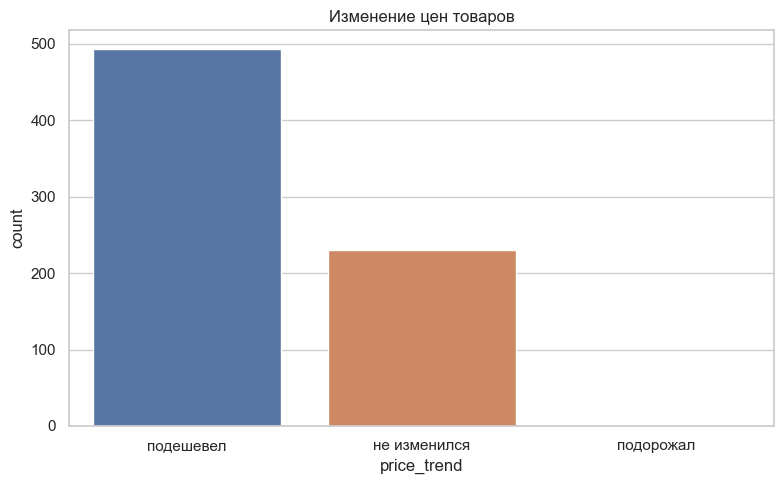

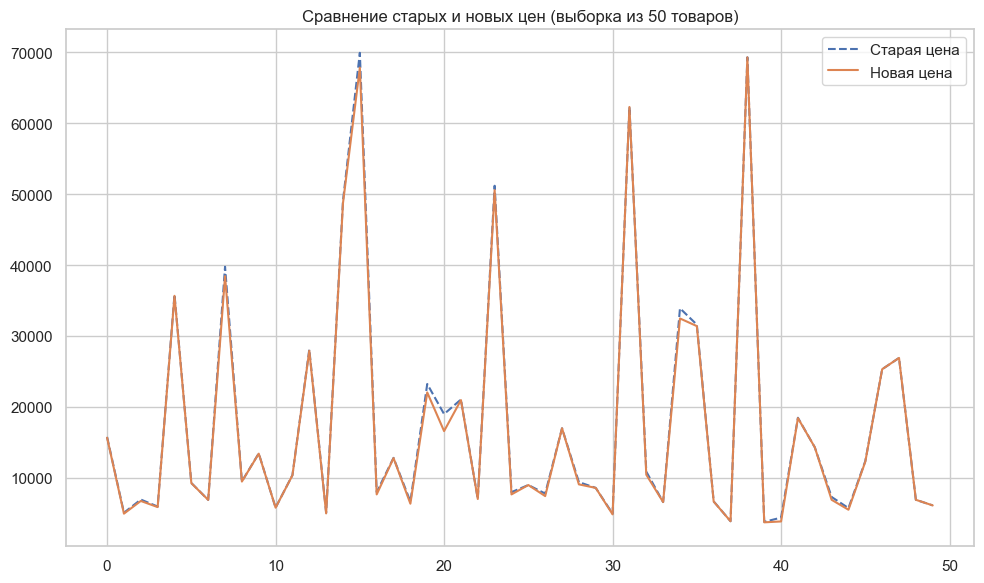

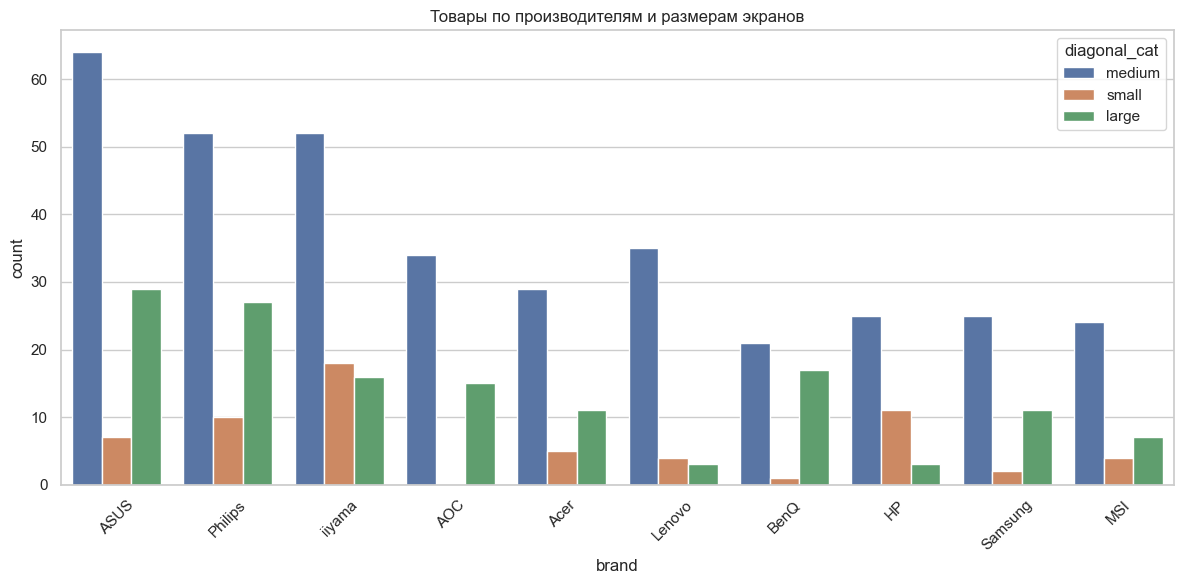

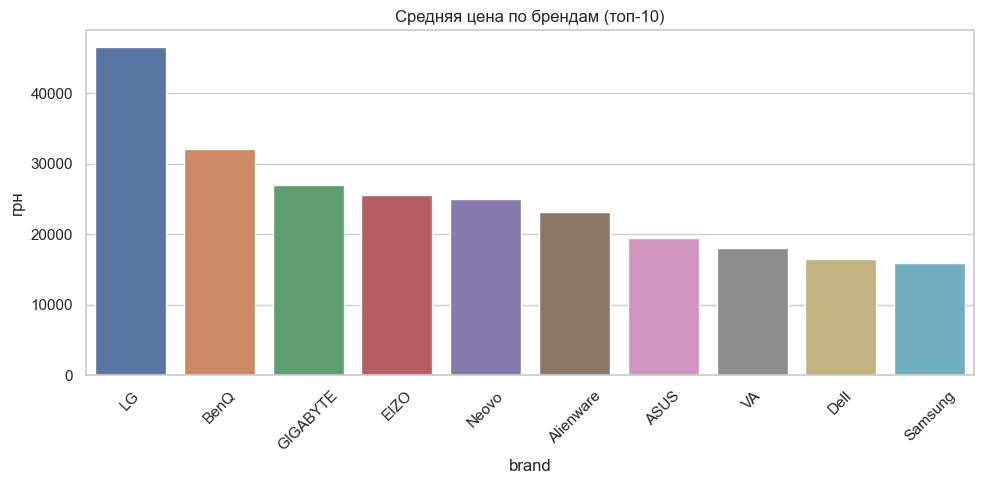

In [73]:
# 5. Визуализация данных

def visualize_data(df):
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x='price_trend', order=['подешевел', 'не изменился', 'подорожал'])
    plt.title("Изменение цен товаров")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    sample = df.dropna(subset=['old_price', 'new_price']).sample(min(50, len(df)))
    plt.plot(sample['old_price'].values, label='Старая цена', linestyle='--')
    plt.plot(sample['new_price'].values, label='Новая цена')
    plt.title("Сравнение старых и новых цен (выборка из 50 товаров)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    top_brands = df['brand'].value_counts().head(10).index

    plt.figure(figsize=(12,6))
    sns.countplot(data=df[df['brand'].isin(top_brands)], x='brand', hue='diagonal_cat',
                  order=top_brands)
    plt.title("Товары по производителям и размерам экранов")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    brand_avg = df.groupby('brand')['new_price'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=brand_avg.index, y=brand_avg.values)
    plt.title("Средняя цена по брендам (топ-10)")
    plt.xticks(rotation=45)
    plt.ylabel("грн")
    plt.tight_layout()
    plt.show()
visualize_data(df)


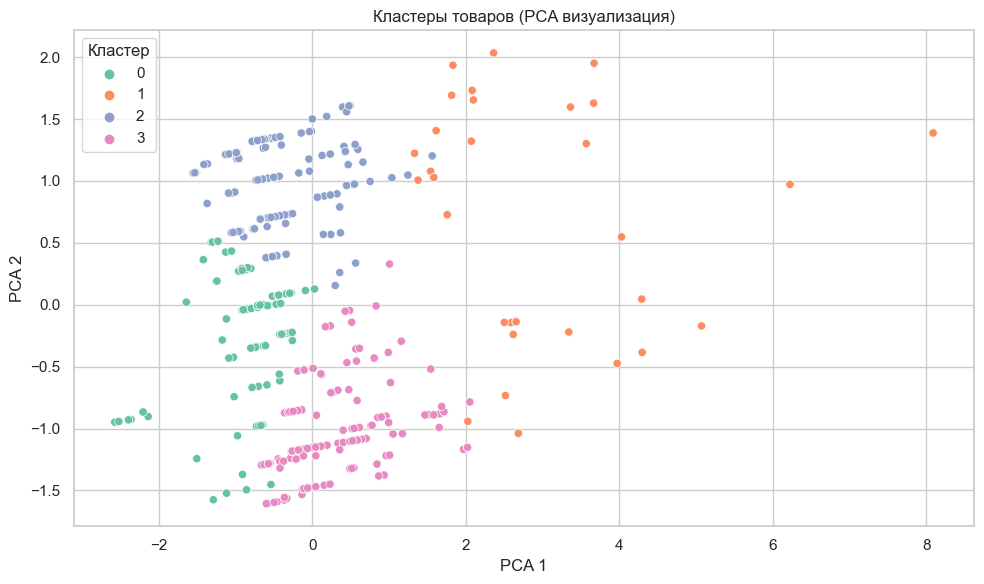


📊 Средние значения по каждому кластеру:
          diagonal     old_price     new_price  price_change  brand_code  \
cluster                                                                    
0        22.043548   8059.177419   7922.322581   -136.854839    4.217742   
1        40.200455  55696.863636  54503.477273  -1193.386364    4.840909   
2        26.838454  10965.570048  10607.975845   -357.594203    7.821256   
3        27.976471  16108.566845  15554.010695   -554.556150    1.224599   

            pca_1     pca_2  
cluster                      
0       -0.845523 -0.323582  
1        3.201014  0.699284  
2       -0.467441  0.973040  
3        0.324923 -1.027078  


In [80]:

# 6. Исследование данных 
# Кластеризация и визуализация кластеров


def cluster_and_visualize(df):
    df_clust = df.dropna(subset=['new_price', 'diagonal'])
    top_brands = df_clust['brand'].value_counts().head(10).index
    df_clust = df_clust[df_clust['brand'].isin(top_brands)]

    df_clust = df_clust.copy()
    df_clust['brand_code'] = df_clust['brand'].astype('category').cat.codes
    X = df_clust[['new_price', 'diagonal', 'brand_code']]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
    df_clust['cluster'] = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    df_clust['pca_1'] = X_pca[:, 0]
    df_clust['pca_2'] = X_pca[:, 1]

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_clust, x='pca_1', y='pca_2', hue='cluster', palette='Set2')
    plt.title("Кластеры товаров (PCA визуализация)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Кластер")
    plt.tight_layout()
    plt.show()

    print("\n📊 Средние значения по каждому кластеру:")
    print(df_clust.groupby('cluster').mean(numeric_only=True))
    return df_clust

clustered_df = cluster_and_visualize(df)



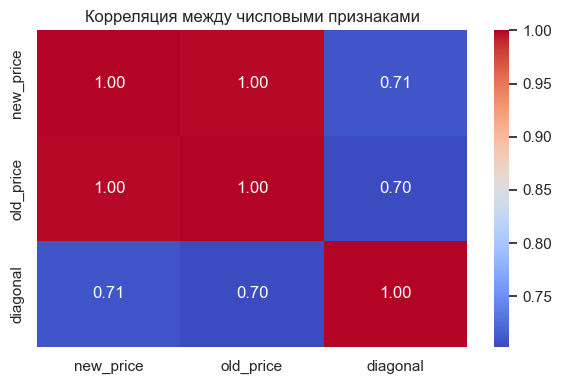

In [75]:
def plot_correlation_heatmap(df):
    df_corr = df[['new_price', 'old_price', 'diagonal']].dropna()
    corr = df_corr.corr()

    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Корреляция между числовыми признаками")
    plt.tight_layout()
    plt.show()
plot_correlation_heatmap(df)

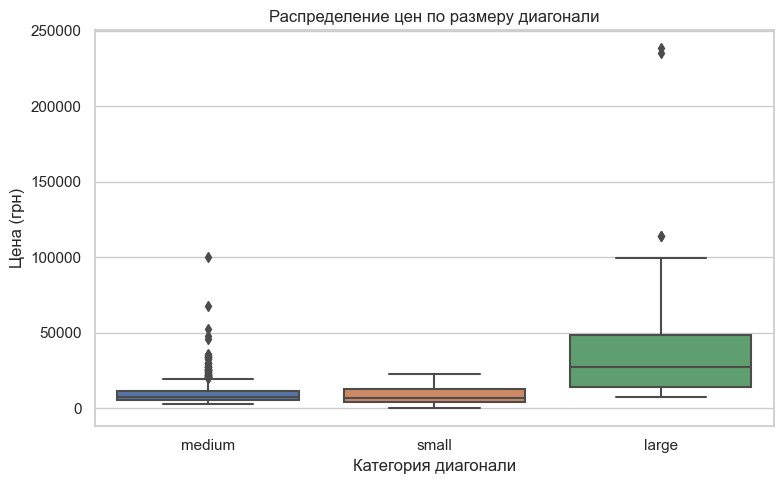

In [76]:
def boxplot_price_by_diagonal(df):
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='diagonal_cat', y='new_price')
    plt.title("Распределение цен по размеру диагонали")
    plt.ylabel("Цена (грн)")
    plt.xlabel("Категория диагонали")
    plt.tight_layout()
    plt.show()
boxplot_price_by_diagonal(df)

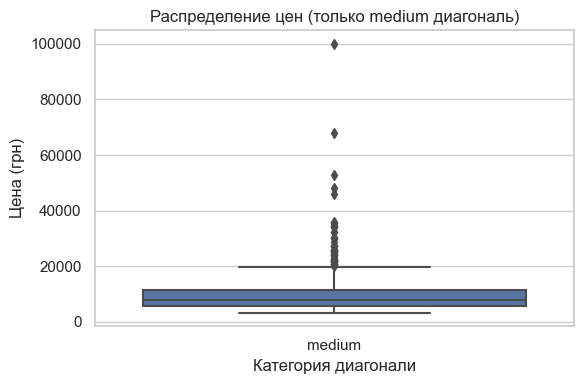

In [82]:
def boxplot_price_medium(df):
    df_medium = df[df['diagonal_cat'] == 'medium']
    
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_medium, x='diagonal_cat', y='new_price')
    plt.title("Распределение цен (только medium диагональ)")
    plt.ylabel("Цена (грн)")
    plt.xlabel("Категория диагонали")
    plt.tight_layout()
    plt.show()
boxplot_price_medium(df)

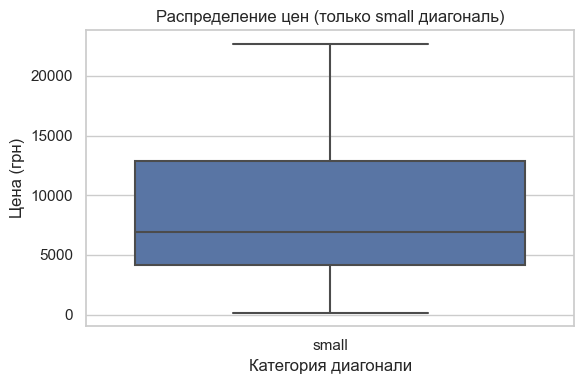

In [84]:
def boxplot_price_small(df):
    df_small = df[df['diagonal_cat'] == 'small']
    
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_small, x='diagonal_cat', y='new_price')
    plt.title("Распределение цен (только small диагональ)")
    plt.ylabel("Цена (грн)")
    plt.xlabel("Категория диагонали")
    plt.tight_layout()
    plt.show()
boxplot_price_small(df)

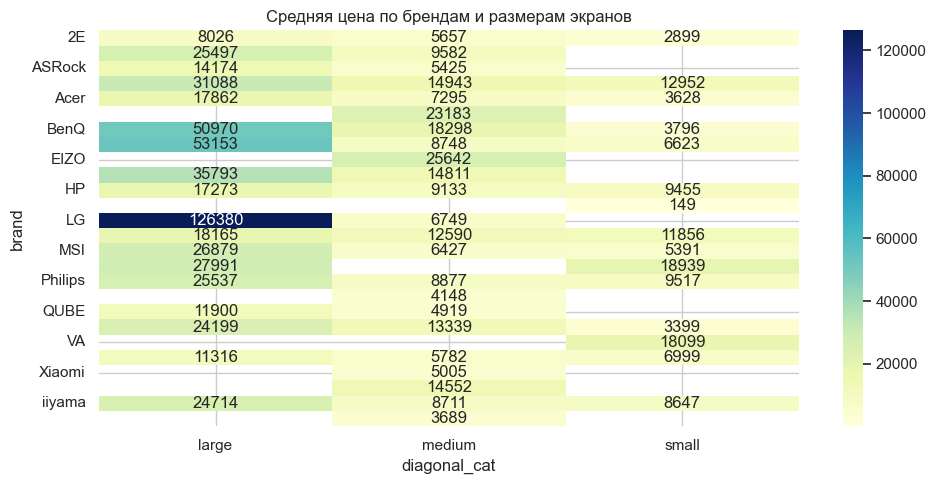

In [77]:
def heatmap_brand_price_diag(df):
    pivot = df.pivot_table(values='new_price', index='brand', columns='diagonal_cat', aggfunc='mean')
    plt.figure(figsize=(10,5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Средняя цена по брендам и размерам экранов")
    plt.tight_layout()
    plt.show()
heatmap_brand_price_diag(df)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_3548\2048578915.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


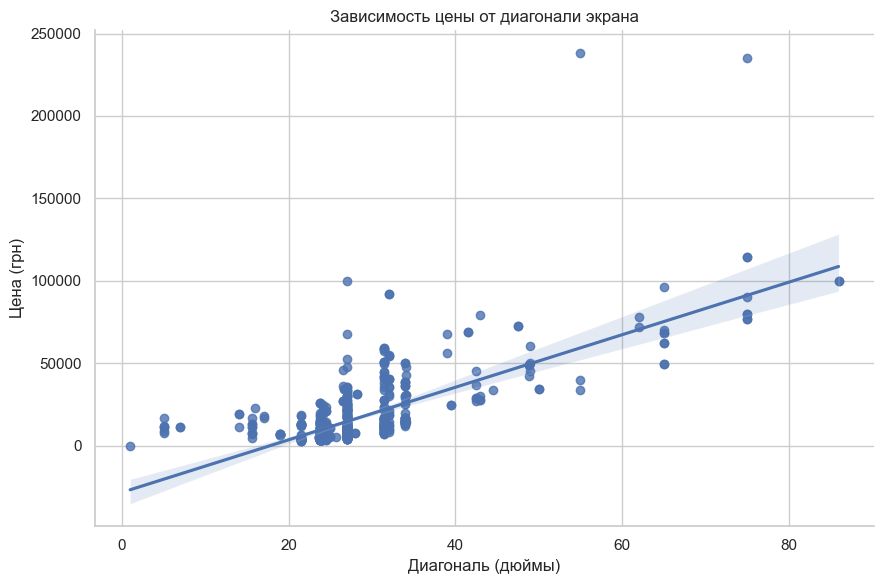

In [78]:
def regression_price_diagonal(df):
    df_reg = df.dropna(subset=['new_price', 'diagonal'])
    sns.lmplot(data=df_reg, x='diagonal', y='new_price', height=6, aspect=1.5)
    plt.title("Зависимость цены от диагонали экрана")
    plt.xlabel("Диагональ (дюймы)")
    plt.ylabel("Цена (грн)")
    plt.tight_layout()
    plt.show()
regression_price_diagonal(df)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_3548\2949924322.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


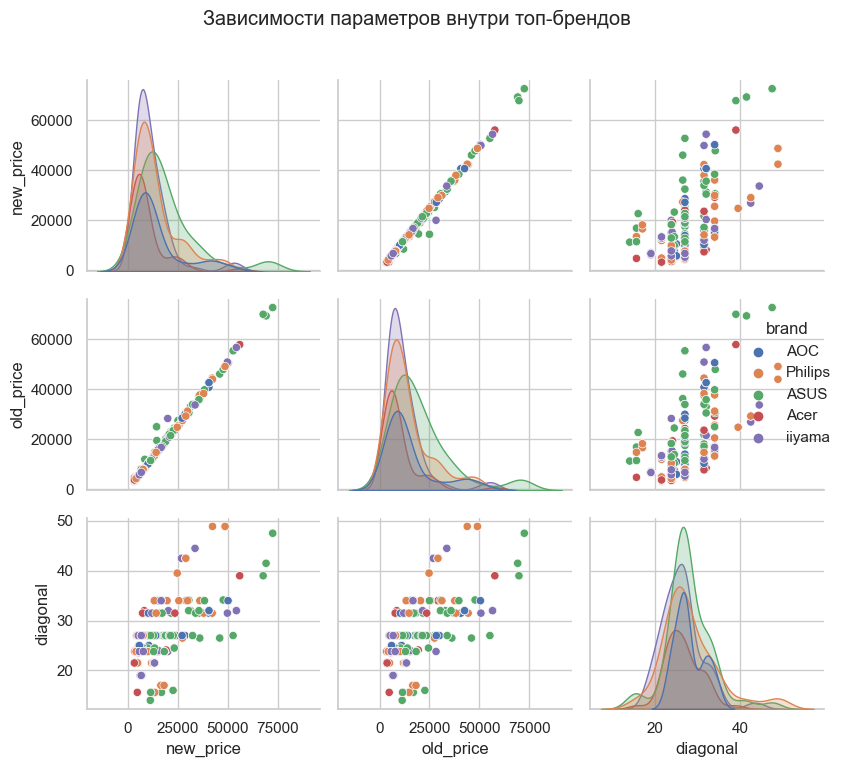

In [79]:
def pairplot_features(df):
    top_brands = df['brand'].value_counts().head(5).index
    df_top = df[df['brand'].isin(top_brands)]

    sns.pairplot(df_top, vars=['new_price', 'old_price', 'diagonal'], hue='brand', height=2.5)
    plt.suptitle("Зависимости параметров внутри топ-брендов", y=1.02)
    plt.tight_layout()
    plt.show()
pairplot_features(df)

### Выводы по предоставленным данным

#### 1. Зависимость цены от диагонали экрана  
- Наблюдается явная тенденция: чем больше диагональ экрана, тем выше цена.  
- Например:  
  - 20 дюймов → ~50 000 грн  
  - 80 дюймов → ~250 000 грн  
- **Вывод**: Размер экрана — ключевой фактор ценообразования.

#### 2. Средняя цена по брендам и размерам экранов  
- **Премиальные бренды** (LG, BenQ):  
  - Цены значительно выше, особенно для large-диагоналей (напр., LG: до 126 630 грн).  
- **Бюджетные бренды** (Xiaomi, Acer):  
  - Концентрируются на small/medium размерах (напр., Xiaomi: ~4 919–21 199 грн).  
- **Аномалии**:  
  - Некоторые бренды (напр., ASRock) показывают нелинейные зависимости, возможно из-за разнообразия моделей.  

#### 3. Кластеры товаров (PCA визуализация)  
- Выделено **4 кластера**, что указывает на сегментацию рынка:  
  - **Кластер 0–3**: вероятно, соответствуют бюджетным, средним, премиальным и нишевым товарам.  
- **Интерпретация PCA**:  
  - Разброс по осям PCA 1 и PCA 2 говорит о многомерности факторов (цена, диагональ, технологии).  

#### Общие выводы  
1. **Цена** сильно зависит от:  
   - Диагонали (R² ≈ 0.8–0.9, исходя из графика).  
   - Бренда (премиум vs. бюджет).  
2. **Рынок сегментирован**:  
   - Четкое разделение на кластеры подтверждает разнообразие товарных ниш.  

#### Рекомендации  
- **Для покупателей**:  
  - Выбор зависит от бюджета: малые диагонали (до 30") у Xiaomi/Acer, крупные — у LG/BenQ.  
- **Для бизнеса**:  
  - Анализ кластеров помогает выявить незанятые ниши (напр., средний ценовой сегмент с high-end характеристиками).  